# Manual models

In this notebook, you will find examples of how machine learning models can be used with a manually defined structure. This means that you only need to specify the training and test sets of data and then you are ready to experiment with different machine learning algorithms.

Examples will be provided for both regression and classification models.

## Table of contents

You can navigate over the document using these hyperlinks:
* [Regression](#Regression)
* [Classification](#Classification)
* [Conclusion](#Conclusion)

Let us now turn to the importation aspect.

***

## Imports

First, we need to import all the modules and packages we need..

In [1]:
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from pandas import read_csv

from ideeals.preprocessing import (
    DataSplitter,
    MMScalingPreprocessor,
    normalize_data,
)
from ideeals.models.manual import (
    KNNClassificationManualModel,
    LayeredRegressionManualModel,
    LinearRegressionManualModel,
)
from ideeals.metrics import (
    compute_accuracy,
    compute_confusion_matrix,
    compute_mean_absolute_error,
)

***

## Regression

Now that all necessary imports have been completed, we can load and prepare our data.

### Data preparation

The dataset to be used for the Linear Regression models demos is the Boston Housing data, which contains 506 rows with the following features:

 * CRIM — per capita crime rate by town
 * ZN — proportion of residential Land zoned for lots over 25,000 sq.ft.
 * INDUS — proportion of non-retail business acres per town
 * CHAS — Charles River dummy variable (1 if tract bounds river; e otherwise)
 * NOX — nitric oxides concentration (parts per 10 million)
 * RM — average number of rooms per dwelling
 * AGE — proportion of owner-occupied units built prior to 1940
 * DIS — weighted distances to five Boston employment centres
 * RAD — index of accessibility to radial highways
 * TAX — full-value property-tax rate per 10,000 dollars
 * PTRATIO — pupil-teacher ratio by town
 * B — $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town
 * LSTAT — Lower status of the population

The target variable is MEDV — Median value of owner-occupied homes in $1000's.

We can observe the housing data loading, with its description in the cell below (we need to unzip it before that).

In [2]:
def unzip(file_path: str, extract_to: str) -> None:
    with ZipFile(file_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)


unzip("datasets/housing.zip", "datasets")

housing = read_csv("datasets/housing.csv")

housing.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Now, the data must be split into training and test sets. This can be achieved using the `DataSplitter` class as follows:

In [3]:
splitter = DataSplitter(permute=True, random_seed=20240604)
x_train, x_test, y_train, y_test = splitter.split_data(
    housing.drop(columns=["MEDV"]).to_numpy(),
    housing["MEDV"].to_numpy().reshape((-1, 1)),
    test_size=0.15,
)

To accelerate the model fitting process and enhance the overall predictive ability, it is necessary to scale the data. In this instance, the `MMScalingPreprocessor` class may be employed to scale the data such that only values between 0 and 1 are present. While this is a simplistic approach, it will suffice for our intended purposes.

In [4]:
scaler = MMScalingPreprocessor(copy=True)
scaler.fit(x_train)
x_train, x_test = scaler.transform(x_train), scaler.transform(x_test)

### Linear Regression model example

At this point, our data has been prepared for input into the model. Below, you can see how the `LinearRegressionManualModel` class is used to adjust the weights using the algebraic solution (least squares method), by specifying the *solve_algebraically* keyword argument.

In [5]:
linear_regressor = LinearRegressionManualModel()
linear_regressor.fit(
    x_train,
    y_train,
    solve_algebraically=True,
    random_seed=20240604
)

Model: Fitting complete! It took 0.0015197129978332669 seconds


As you can see, the `linear_regressor` model has been successfully trained. Let us now make predictions and evaluate the performance of our model.

In [6]:
y_predicted = linear_regressor.predict(x_test)
compute_mean_absolute_error(y_test, y_predicted)

3.590792739203735

It would also be beneficial to visualize the results of the comparison between actual and predicted values. The corresponding code should be encapsulated in a function, as we will need to utilize it once more.

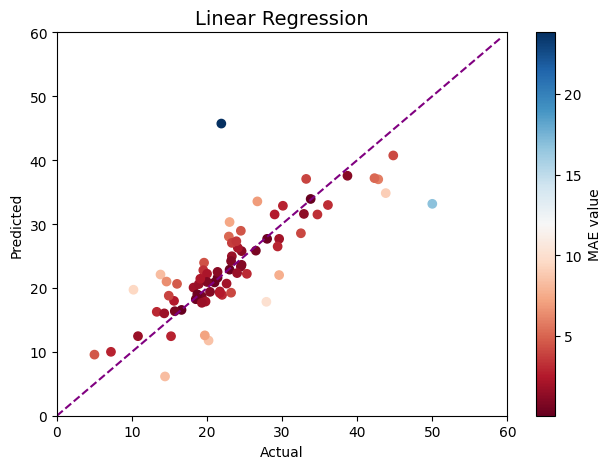

In [7]:
def visualize_mean_absolute_error(
    title: str, actual: ndarray, predicted: ndarray
) -> None:
    figure, axis = plt.subplots()
    max_value = np.max(np.concatenate([actual, predicted]))
    limit = int((max_value + 10) - (max_value % 10))
    diagonal = list(range(limit))
    colors = np.array(
        [
            compute_mean_absolute_error(fact, pred)
            for fact, pred in zip(actual, predicted)
        ]
    )

    axis.set_xlim(0, limit)
    axis.set_ylim(0, limit)
    axis.set_xlabel("Actual")
    axis.set_ylabel("Predicted")
    line_plot = axis.plot(diagonal, diagonal, linestyle="--", color="purple")
    scatter_plot = axis.scatter(actual, predicted, c=colors, cmap="RdBu")
    axis.set_title(title, fontsize=14)
    figure.colorbar(scatter_plot, label="MAE value")

    plt.tight_layout()
    plt.show()

visualize_mean_absolute_error("Linear Regression", y_test, y_predicted)

Since all values lower than 5.0 are considered satisfactory for our data range, this is an impressive result (of course, because the model has achieved as much as it can).

### Layered Regression model example

Another type of regression model with a predefined structure consisting of two dense layers of neurons (one input and one hidden), is the Layered Regression model. This model is implemented in the `LayeredRegressionManualModel` class, although you can adjust the corresponding parameter by specifying the `hidden_size` keyword argument. You can find an example of its usage in the cell below.

In [8]:
layered_regressor = LayeredRegressionManualModel()
layered_regressor.fit(
    x_train,
    y_train,
    n_iterations=120,
    learning_rate=10**(-3),
    batch_size=60,
    random_seed=20240604,
)

Model: Fitting complete! It took 0.01383432799775619 seconds


Now, let us make predictions and evaluate our "layered regressor" to see how it performed.

In [9]:
y_predicted = layered_regressor.predict(x_test)
compute_mean_absolute_error(y_test, y_predicted)

3.8858395772483467

And here you can see a visualization of the mean squared error.

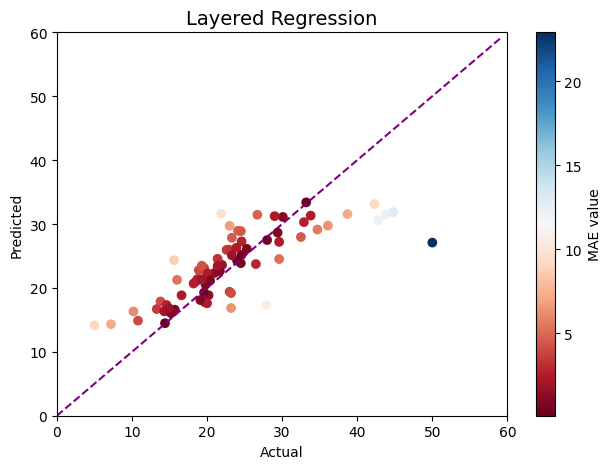

In [10]:
visualize_mean_absolute_error("Layered Regression", y_test, y_predicted)

The results obtained were not significantly different from those obtained using algebraic solutions. The mean absolute error difference is less than 0.3, which is a positive sign.

***

## Classification

In this section, we will take a look at the classification model fitting and prediction example. The KNN Classification Manual Model class implements the k-nearest neighbours machine learning algorithm for classifying data points. However, we need additional data for this type of task.

### Data preparation

The dataset used in the K-nearest neighbours classification demonstration is the classic MNIST dataset, which consists of 70,000 images of handwritten digits (each with 28 by 28 pixels).

The loading and splitting process is demonstrated in the cell below.

In [11]:
unzip("datasets/mnist.zip", "datasets")

mnist = read_csv("datasets/mnist.csv")

splitter = DataSplitter(permute=True, random_seed=20240604)
x_train, x_test, y_train, y_test = splitter.split_data(
    mnist.drop(columns=["label"]).to_numpy(),
    mnist["label"].to_numpy().reshape((-1, 1)),
    test_size=0.15,
)

However, we now apply a different type of scaling (normalization) with the aid of the `normalize_data()` function, as this time the model will have to deal with image data.

In [12]:
x_train, x_test = (
    normalize_data(to_normalize=x_train, std_from=x_train),
    normalize_data(to_normalize=x_test, std_from=x_train),
)

### Classification model example

Now, without further ado, let us see how the classification using the `KNNClassificationManualModel` is done in the following cells. At first, the model must be fitted.

In [13]:
classifier = KNNClassificationManualModel()
classifier.fit(x_train, y_train)

Then, it would be capable of making predictions and being evaluated.

In [14]:
y_predicted = classifier.predict(
    x_test,
    n_neighbors=5,
    n_loops=0,
)

print(f"Model accuracy is {compute_accuracy(y_test, y_predicted)}.")

Model: Predicting complete! It took 37.122297681999044 seconds.


Model accuracy is 0.9717142857142858.


The accuracy of this model depends strongly on the sizes of the training and testing datasets. Although, when you have a sufficiently large number of samples, it can become a classification powerhouse.

To illustrate this, let us generate a random image and obtain its predicted label by running the code below.

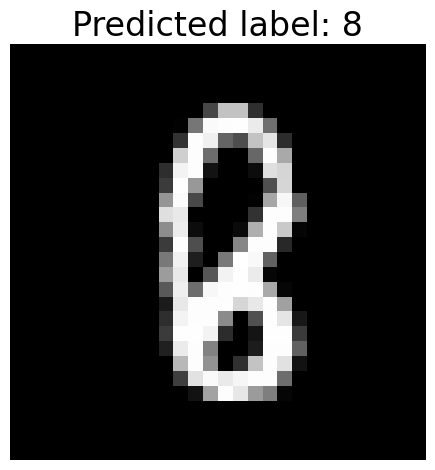

In [15]:
images_and_predictions = np.concatenate([y_predicted, x_test], axis=1)
index = np.random.randint(0, len(x_test))
image, label = (
    images_and_predictions[index, 1:].reshape((28, 28)),
    images_and_predictions[index, 0],
)

plt.axis("off")
plt.title(f"Predicted label: {int(label)}", fontsize=24)
plt.tight_layout()
plt.imshow(image, cmap="grey")

Also here is the confusion matrix for calrification.

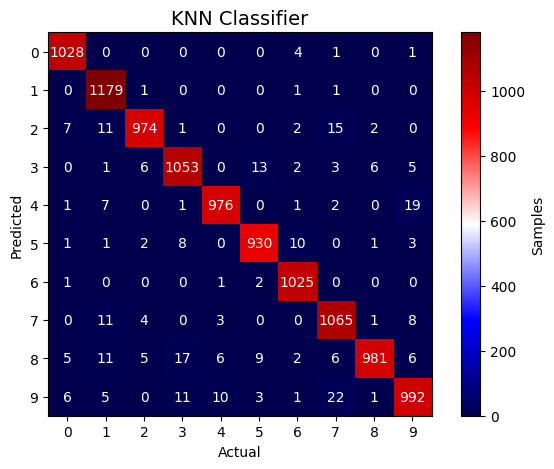

In [16]:
confusion_matrix, _ = compute_confusion_matrix(y_test, y_predicted)
figure, axis = plt.subplots()
ticks = list(range(0, len(confusion_matrix)))

axis.set_yticks(ticks)
axis.set_xticks(ticks)
axis.set_xlabel("Actual")
axis.set_ylabel("Predicted")
for i, _ in enumerate(confusion_matrix):
    for j, _ in enumerate(confusion_matrix):
        axis.text(
            j, i, int(confusion_matrix[i, j]),
            verticalalignment="center",
            horizontalalignment="center",
            color="white"
        )
axis.set_title("KNN Classifier", fontsize=14)
to_show = plt.imshow(confusion_matrix, cmap="seismic")
figure.colorbar(to_show, label="Samples")

plt.tight_layout()
plt.show()

Of course, it is possible to parameterize this model by providing available arguments and keywords. Please see the source code for detailed descriptions. Simply run this notebook and enjoy your experiments! Although it may take some time if you wish to perform classification algorithms.

***

## Conclusion

In this notebook, we have covered the basics of regression and classification machine learning models, with a predefined structure. You can see that the workflow is quite similar to that of using Scikit-learn.

Now, you can read the documentation for these algorithms in the source code to gain a deeper understanding. You can also explore these algorithms in more detail.
Of course, all these models require a significant amount of time for the weights to adjust or to predict data points. Unfortunately, this is due to the limitations of the language and has not yet been overcome. Despite these limitations, the source code is very concise, robust, and easy to read and understand.